<a href="https://colab.research.google.com/github/Saroramath/MachineLearning/blob/main/6205A/6205A3TempData12Hr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning goals

1. Prepare the time series data into samples.
2. We will us primitive commands to understand the sample generation steps.

In [1]:
!pip install netCDF4

     |████████████████████████████████| 4.7MB 8.3MB/s 
     |████████████████████████████████| 317kB 42.5MB/s 


In [2]:
from netCDF4 import Dataset
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [3]:
from google.colab import files
#uploaded = files.upload()

In [4]:
#drive.mount('/content/gdrive')

> The file is too big to call as raw from github or to use upload. 

Upload the file in sample_data directory from system.

In [5]:
file = '/content/sample_data/tempStJohns.nc'

# Explore the data

In [6]:
df = Dataset(file)

In [7]:
df

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2021-02-03 00:49:51 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data2/adaptor.mars.internal-1612306467.0641284-4955-27-685dbd6e-9572-4267-a9a7-5a61b7e919e4.nc /cache/tmp/685dbd6e-9572-4267-a9a7-5a61b7e919e4-adaptor.mars.internal-1612306467.0646257-4955-9-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), expver(2), time(87672)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 t2m(time, expver, latitude, longitude)
    groups: 

In [8]:
df['longitude'][0] #longitude of the place

masked_array(data=-52.75,
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [9]:
df['time'] # Time series units: hours since 1900-01-01 00:00:00.0

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (87672,)
filling on, default _FillValue of -2147483647 used

In [10]:
time = df['time'][:] #start value 973008, end value 1060679

In [11]:
time

masked_array(data=[ 973008,  973009,  973010, ..., 1060677, 1060678,
                   1060679],
             mask=False,
       fill_value=999999,
            dtype=int32)

In [12]:
time.shape

(87672,)

> Consider columns with time data

In [13]:
 df['t2m'][:,0,0,0]

masked_array(data=[272.81080791804084, 272.6567134137989,
                   272.7837285490946, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-32767)

> Convert to Celsius

In [14]:
temp = df['t2m'][:,0,0,0]-273.15

> Masked arrays are arrays that may have missing or invalid entries. The numpy.ma module provides a nearly work-alike replacement for numpy that supports data arrays with masks.



In [15]:
temp 

masked_array(data=[-0.3391920819591405, -0.4932865862010658,
                   -0.36627145090540125, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-32767)

 The array is masked, filled with -32767 for the missing values, mask tells us where is that happeneing.

In [16]:
temp.data 

array([-3.39192082e-01, -4.93286586e-01, -3.66271451e-01, ...,
       -3.27670000e+04, -3.27670000e+04, -3.27670000e+04])

In [17]:
temp.shape

(87672,)

In [18]:
temp.mask

array([False, False, False, ...,  True,  True,  True])

## Rmoving masked values.

First we check if the masked values are continuous or not.

In [19]:
missing = np.where(temp.mask == True)

In [20]:
missing[0][0] # The missing data is infact continuous so our time series is not broken anywhere

86928

In [21]:
temp = temp[~temp.mask] #use the inverse of the mask as an index.

In [22]:
temp.shape # This is a continuous time series for temperature.

(86928,)

Reducing time seris to match with it

In [23]:
time = time[:86928]

In [24]:
time.shape

(86928,)

Find the unique value in numpy

In [25]:
np.unique(temp.mask) #All values are genuine now

array([False])

## Plot the temperature over time.

Plot the time series against time




In [26]:
number_of_years = (time-973008)/8760 

Temperature plot over approximately 10 years

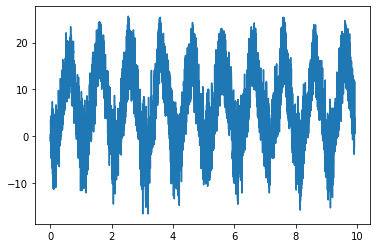

In [27]:
plt.plot(number_of_years,temp)

## Standardize the temperature

In [28]:
temp.shape

(86928,)

In [29]:
temp.mean()

5.57589982331033

In [30]:
temp.std()

7.754305350561417

(array([  297.,  2100.,  6706., 15629., 17035., 14113., 12733., 11795.,
         5601.,   919.]),
 array([-16.62485352, -12.39963379,  -8.17441406,  -3.94919434,
          0.27602539,   4.50124512,   8.72646484,  12.95168457,
         17.1769043 ,  21.40212402,  25.62734375]),
 <a list of 10 Patch objects>)

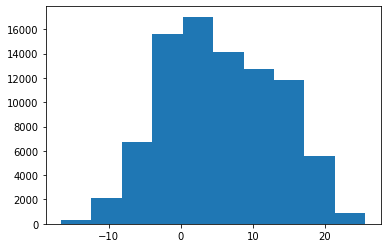

In [31]:
plt.hist(temp)

In [32]:
#temp = (temp - temp.mean())/temp.std()

In [33]:
temp.mean()

5.57589982331033

In [34]:
temp.std()

7.754305350561417

In [35]:
temp.max()

25.627343750000023

In [36]:
temp.min()

-16.624853515624977

## Generate Samples

We will avoid using functions to generate smaples to understand the process.

We want the prediction model to predict the next 6 hr of data with previous 6 hrs of temp data available.

In [37]:
temp[0:6]

masked_array(data=[-0.3391920819591405, -0.4932865862010658,
                   -0.36627145090540125, -0.1728473870034577,
                   -0.26569093767636787, -0.4346146201507963],
             mask=[False, False, False, False, False, False],
       fill_value=-32767)

We make the vectors of size 6

In [38]:
future = 6
past = 12

In [39]:
data = []

for i in range(len(temp)- (future + past)  +1):
  data.append(temp[i:i+past].data)
data  = np.array(data) 

In [40]:
label = []
for i in range(len(temp)- (future + past)  +1):
  label.append(temp[i+ past:i+past + future].data)

label = np.array(label)


In [41]:
#no of samples
n_dataSample = len(temp)-past-future +1
print(n_dataSample)

86911


In [42]:
data.shape

(86911, 12)

In [43]:
label.shape

(86911, 6)

> Split the samples into train and test data

In [44]:
temp_train_number = np.int(0.8*len(data))

In [45]:
temp_train_number

69528

In [46]:
train_temp = data[:temp_train_number]

In [47]:
train_temp.shape

(69528, 12)

In [48]:
train_temp[temp_train_number-1]

array([-1.99554682, -1.93300637, -1.8537025 , -1.38819526, -1.04003194,
       -0.77310673, -0.56485349, -0.4797469 , -0.47200994, -0.68284217,
       -0.84338414, -1.15157315])

In [49]:
train_label = label[:temp_train_number]

In [50]:
train_label.shape

(69528, 6)

In [51]:
test_temp = data[temp_train_number:]

In [52]:
test_label = label[temp_train_number:]

In [53]:
print(test_label.shape)
print(test_temp.shape)

(17383, 6)
(17383, 12)


In [54]:
test_temp[1].shape

(12,)

#  Persistence Model

In [55]:
def model_persistence(test_temp_entry):
  arr = np.full((future,),test_temp_entry[past-1])

  return arr

In [56]:
test_temp[1]

array([-1.8537025 , -1.38819526, -1.04003194, -0.77310673, -0.56485349,
       -0.4797469 , -0.47200994, -0.68284217, -0.84338414, -1.15157315,
       -1.24312721, -1.32629955])

In [57]:
model_persistence(test_temp[1])

array([-1.32629955, -1.32629955, -1.32629955, -1.32629955, -1.32629955,
       -1.32629955])

In [58]:
def y_persis(test_temp):
  arr = np.empty(test_label.shape)
  for i in range(len(test_temp)):
    arr[i] = model_persistence(test_temp[i])
  return arr    

In [59]:
test_temp.shape

(17383, 12)

In [60]:
y_persistence = y_persis(test_temp)

### MSE_Persistence

In [61]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [62]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_persistence))
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_persistence))

Mean squared error: 2.91
Coefficient of determination: 0.95


### Plot the temp

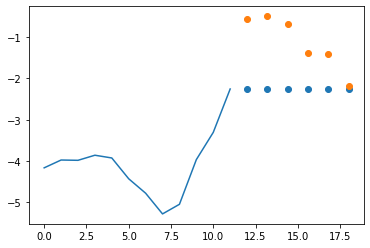

In [63]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[101])
plt.scatter(z,y_persistence[101])
plt.scatter(z,test_label[101])

# Linear regression using Sklearn

In [64]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [65]:
linear_regression = linear_model.LinearRegression()

In [66]:
linear_regression.fit(train_temp, train_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [67]:
predict_label = linear_regression.predict(test_temp)

### MSE_Linear_Regression

In [68]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, predict_label))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, predict_label))

Mean squared error: 2.03
Coefficient of determination: 0.97


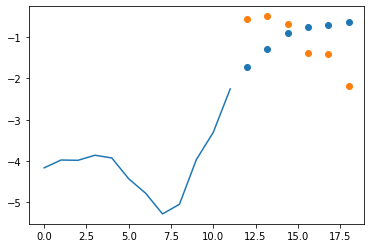

In [69]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[101])
plt.scatter(z,predict_label[101])
plt.scatter(z,test_label[101])

# Neural Network

## Normalize the data

In [70]:
train_temp_max = train_temp.max()
train_temp_min = train_temp.min()

train_temp_norm = (train_temp- train_temp_min)/(train_temp_max-train_temp_min)
test_temp_norm = (test_temp- train_temp_min)/(train_temp_max-train_temp_min)

train_label_norm = (train_label- train_temp_min)/(train_temp_max-train_temp_min)
test_label_norm = (test_label- train_temp_min)/(train_temp_max-train_temp_min)



In [71]:
train_temp.max()

25.627343750000023

In [72]:
train_label.min()

-16.624853515624977

In [73]:
#inp = tf.keras.layers.Input(shape=(6,))     # Sequential api
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
##b = tf.keras.layers.Dense(128,activation='relu')(inp)
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
#out = tf.keras.layers.Dense(6, activation='linear')(b)

#model = tf.keras.models.Model(inp,out)
#model.summary()

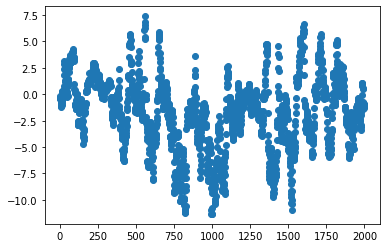

In [74]:
axis = np.linspace(0,1999,2000)
axisy = temp[0:2000]
plt.scatter(axis,axisy)

## Model

In [75]:
model = tf.keras.models.Sequential([
  
  tf.keras.layers.Input(shape=(past,)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(future, activation='linear')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),'accuracy']
)

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1664      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 35,462
Trainable params: 35,462
Non-trainable params: 0
_________________________________________________________________


In [76]:
test = test_temp_norm, test_label_norm

In [77]:
hist = model.fit(train_temp_norm,train_label_norm ,batch_size=64, epochs=40,callbacks = tf.keras.callbacks.EarlyStopping(patience=5), validation_data= test)

Epoch 1/40
1087/1087 [==============================] - 3s 3ms/step - loss: 0.0121 - mean_absolute_error: 0.0568 - accuracy: 0.2899 - val_loss: 0.0011 - val_mean_absolute_error: 0.0238 - val_accuracy: 0.5049
Epoch 2/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0262 - accuracy: 0.4301 - val_loss: 0.0011 - val_mean_absolute_error: 0.0233 - val_accuracy: 0.4991
Epoch 3/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0254 - accuracy: 0.4546 - val_loss: 0.0011 - val_mean_absolute_error: 0.0225 - val_accuracy: 0.5074
Epoch 4/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0255 - accuracy: 0.4645 - val_loss: 0.0011 - val_mean_absolute_error: 0.0228 - val_accuracy: 0.5215
Epoch 5/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0249 - accuracy: 0.4599 - val_loss: 0.0011 - val_mean_absolu

In [78]:
test_temp

array([[-1.93300637, -1.8537025 , -1.38819526, ..., -0.84338414,
        -1.15157315, -1.24312721],
       [-1.8537025 , -1.38819526, -1.04003194, ..., -1.15157315,
        -1.24312721, -1.32629955],
       [-1.38819526, -1.04003194, -0.77310673, ..., -1.24312721,
        -1.32629955, -1.44493298],
       ...,
       [ 2.26300632,  2.15662309,  2.12567524, ...,  2.18370246,
         2.84908124,  3.12825664],
       [ 2.15662309,  2.12567524,  2.0921484 , ...,  2.84908124,
         3.12825664,  3.38099741],
       [ 2.12567524,  2.0921484 ,  2.09021416, ...,  3.12825664,
         3.38099741,  3.79363542]])

In [79]:
prediction = model.predict(test_temp_norm)

In [80]:
prediction.shape

(17383, 6)

In [81]:
test_label_norm.shape

(17383, 6)

In [82]:
model.evaluate(test_temp_norm,  test_label_norm, verbose=2)

544/544 - 0s - loss: 0.0011 - mean_absolute_error: 0.0227 - accuracy: 0.4674


[0.0010501774959266186, 0.022697294130921364, 0.467410683631897]

## Scale back to prediction temperature

In [83]:
y_predict_norm = model.predict(test_temp_norm)

In [84]:
y_predict = train_temp_min + y_predict_norm * (train_temp_max-train_temp_min)

##MSE_Neural_Network

In [85]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_predict))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_predict))

Mean squared error: 1.87
Coefficient of determination: 0.97


## Plot the temp

In [86]:
z = np.linspace(past, past+future,future)

In [87]:
test_temp[0]

array([-1.93300637, -1.8537025 , -1.38819526, -1.04003194, -0.77310673,
       -0.56485349, -0.4797469 , -0.47200994, -0.68284217, -0.84338414,
       -1.15157315, -1.24312721])

In [88]:
test_label[0]

array([-1.32629955, -1.44493298, -1.40689291, -1.32952329, -1.26891708,
       -1.02520276])

In [89]:
y_predict[0]


array([-1.3430233, -1.3526154, -1.3555241, -1.543087 , -1.6403952,
       -1.7510853], dtype=float32)

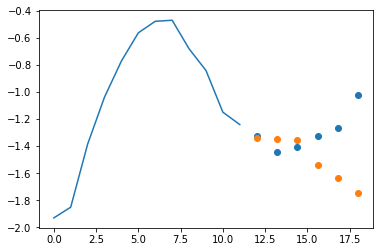

In [90]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[0])
plt.scatter(z,test_label[0])
plt.scatter(z,y_predict[0])

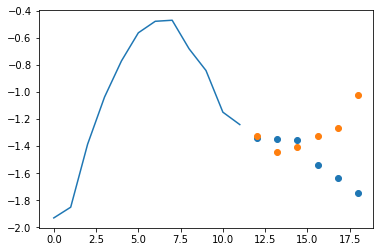

In [91]:
i = 0
plt.plot(test_temp[i])
plt.scatter(z,y_predict[i])
plt.scatter(z,test_label[i]) # What shappeneing is that predicted values are so large in comparison to the test amd label values that is approximately starilght line

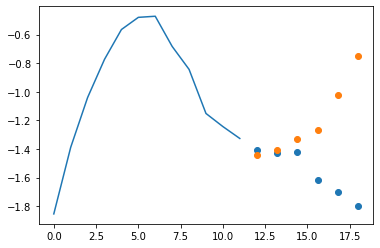

In [92]:
i = 1
plt.plot(test_temp[i])
plt.scatter(z,y_predict[i])
plt.scatter(z,test_label[i])

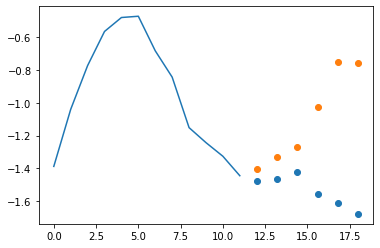

In [93]:
i = 2
plt.plot(test_temp[i])
plt.scatter(z,y_predict[i])
plt.scatter(z,test_label[i])

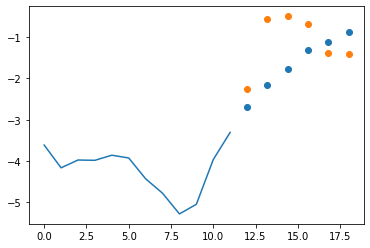

In [94]:
i = 100
plt.plot(test_temp[i])
plt.scatter(z,y_predict[i])
plt.scatter(z,test_label[i])

# Neural Network 2

## Normalize the data

In [95]:
train_temp_max = train_temp.max()
train_temp_min = train_temp.min()

train_temp_norm = (train_temp- train_temp_min)/(train_temp_max-train_temp_min)
test_temp_norm = (test_temp- train_temp_min)/(train_temp_max-train_temp_min)

train_label_norm = (train_label- train_temp_min)/(train_temp_max-train_temp_min)
test_label_norm = (test_label- train_temp_min)/(train_temp_max-train_temp_min)



In [96]:
train_temp.max()

25.627343750000023

In [97]:
train_label.min()

-16.624853515624977

In [98]:
#inp = tf.keras.layers.Input(shape=(6,))     # Sequential api
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
##b = tf.keras.layers.Dense(128,activation='relu')(inp)
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
#out = tf.keras.layers.Dense(6, activation='linear')(b)

#model = tf.keras.models.Model(inp,out)
#model.summary()

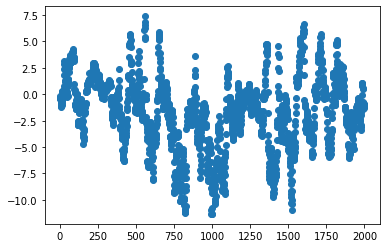

In [99]:
axis = np.linspace(0,1999,2000)
axisy = temp[0:2000]
plt.scatter(axis,axisy)

## Model

In [100]:
model = tf.keras.models.Sequential([
  
  tf.keras.layers.Input(shape=(past,)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(future, activation='linear')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.SGD(),
                metrics=[tf.metrics.MeanAbsoluteError(),'accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               1664      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 774       
Total params: 35,462
Trainable params: 35,462
Non-trainable params: 0
_________________________________________________________________


In [101]:
test = test_temp_norm, test_label_norm

In [102]:
hist = model.fit(train_temp_norm,train_label_norm ,batch_size=64, epochs=40,callbacks = tf.keras.callbacks.EarlyStopping(patience=3), validation_data= test)

Epoch 1/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0404 - mean_absolute_error: 0.1307 - accuracy: 0.1377 - val_loss: 0.0045 - val_mean_absolute_error: 0.0535 - val_accuracy: 0.1439
Epoch 2/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0045 - mean_absolute_error: 0.0527 - accuracy: 0.1477 - val_loss: 0.0037 - val_mean_absolute_error: 0.0480 - val_accuracy: 0.1474
Epoch 3/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0038 - mean_absolute_error: 0.0486 - accuracy: 0.1491 - val_loss: 0.0034 - val_mean_absolute_error: 0.0459 - val_accuracy: 0.1820
Epoch 4/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0035 - mean_absolute_error: 0.0465 - accuracy: 0.1670 - val_loss: 0.0032 - val_mean_absolute_error: 0.0445 - val_accuracy: 0.1643
Epoch 5/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0033 - mean_absolute_error: 0.0449 - accuracy: 0.1717 - val_loss: 0.0030 - val_mean_absolu

In [103]:
test_temp

array([[-1.93300637, -1.8537025 , -1.38819526, ..., -0.84338414,
        -1.15157315, -1.24312721],
       [-1.8537025 , -1.38819526, -1.04003194, ..., -1.15157315,
        -1.24312721, -1.32629955],
       [-1.38819526, -1.04003194, -0.77310673, ..., -1.24312721,
        -1.32629955, -1.44493298],
       ...,
       [ 2.26300632,  2.15662309,  2.12567524, ...,  2.18370246,
         2.84908124,  3.12825664],
       [ 2.15662309,  2.12567524,  2.0921484 , ...,  2.84908124,
         3.12825664,  3.38099741],
       [ 2.12567524,  2.0921484 ,  2.09021416, ...,  3.12825664,
         3.38099741,  3.79363542]])

In [104]:
prediction = model.predict(test_temp_norm)

In [105]:
prediction.shape

(17383, 6)

In [106]:
test_label_norm.shape

(17383, 6)

In [107]:
model.evaluate(test_temp_norm,  test_label_norm, verbose=2)

544/544 - 0s - loss: 0.0014 - mean_absolute_error: 0.0266 - accuracy: 0.4174


[0.0013790796510875225, 0.026606295257806778, 0.41741931438446045]

## Scale back to prediction temperature

In [108]:
y_predict_norm = model.predict(test_temp_norm)

In [109]:
y_predict2 = train_temp_min + y_predict_norm * (train_temp_max-train_temp_min)

##MSE_Neural_Network2






In [110]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_predict2))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_predict2))

Mean squared error: 2.46
Coefficient of determination: 0.96


## Plot the temp

In [111]:
z = np.linspace(past, past+future,future)

In [112]:
test_temp[0]

array([-1.93300637, -1.8537025 , -1.38819526, -1.04003194, -0.77310673,
       -0.56485349, -0.4797469 , -0.47200994, -0.68284217, -0.84338414,
       -1.15157315, -1.24312721])

In [113]:
test_label[0]

array([-1.32629955, -1.44493298, -1.40689291, -1.32952329, -1.26891708,
       -1.02520276])

In [114]:
y_predict2[0]


array([-1.474472 , -1.5684814, -1.4621067, -1.5065956, -1.4940643,
       -1.3902092], dtype=float32)

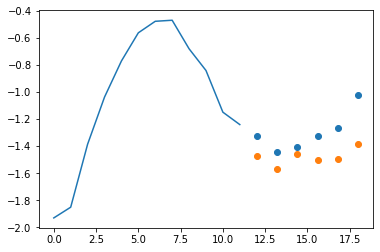

In [115]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[0])
plt.scatter(z,test_label[0])
plt.scatter(z,y_predict2[0])

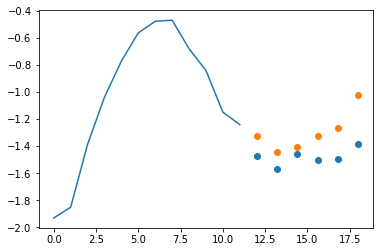

In [116]:
i = 0
plt.plot(test_temp[i])
plt.scatter(z,y_predict2[i])
plt.scatter(z,test_label[i]) # What shappeneing is that predicted values are so large in comparison to the test amd label values that is approximately starilght line

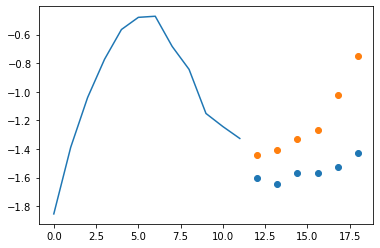

In [117]:
i = 1
plt.plot(test_temp[i])
plt.scatter(z,y_predict2[i])
plt.scatter(z,test_label[i])

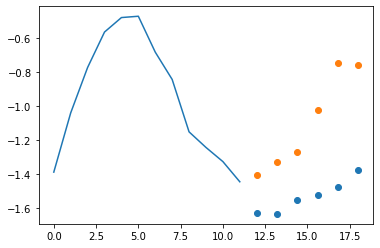

In [118]:
i = 2
plt.plot(test_temp[i])
plt.scatter(z,y_predict2[i])
plt.scatter(z,test_label[i])

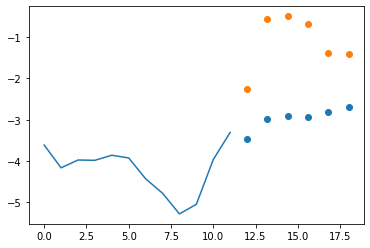

In [119]:
i = 100
plt.plot(test_temp[i])
plt.scatter(z,y_predict2[i])
plt.scatter(z,test_label[i])

# Neural Network 3

## Normalize the data

In [120]:
train_temp_max = train_temp.max()
train_temp_min = train_temp.min()

train_temp_norm = (train_temp- train_temp_min)/(train_temp_max-train_temp_min)
test_temp_norm = (test_temp- train_temp_min)/(train_temp_max-train_temp_min)

train_label_norm = (train_label- train_temp_min)/(train_temp_max-train_temp_min)
test_label_norm = (test_label- train_temp_min)/(train_temp_max-train_temp_min)



In [121]:
train_temp.max()

25.627343750000023

In [122]:
train_label.min()

-16.624853515624977

In [123]:
#inp = tf.keras.layers.Input(shape=(6,))     # Sequential api
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
##b = tf.keras.layers.Dense(128,activation='relu')(inp)
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
#out = tf.keras.layers.Dense(6, activation='linear')(b)

#model = tf.keras.models.Model(inp,out)
#model.summary()

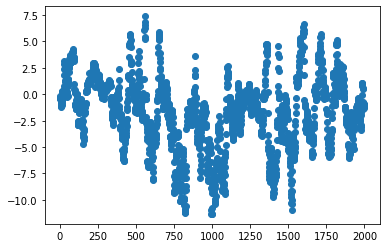

In [124]:
axis = np.linspace(0,1999,2000)
axisy = temp[0:2000]
plt.scatter(axis,axisy)

## Model

In [125]:
model = tf.keras.models.Sequential([
  
  tf.keras.layers.Input(shape=(past,)),
  tf.keras.layers.Dense(128,activation='tanh'),
  tf.keras.layers.Dense(128,activation='tanh'),
  tf.keras.layers.Dense(128,activation='tanh'),
  tf.keras.layers.Dense(future, activation='linear')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),'accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               1664      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 774       
Total params: 35,462
Trainable params: 35,462
Non-trainable params: 0
_________________________________________________________________


In [126]:
test = test_temp_norm, test_label_norm

In [127]:
hist = model.fit(train_temp_norm,train_label_norm ,batch_size=64, epochs=40,callbacks = tf.keras.callbacks.EarlyStopping(patience=3), validation_data= test)

Epoch 1/40
1087/1087 [==============================] - 3s 2ms/step - loss: 0.0067 - mean_absolute_error: 0.0468 - accuracy: 0.3323 - val_loss: 0.0013 - val_mean_absolute_error: 0.0266 - val_accuracy: 0.2541
Epoch 2/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0015 - mean_absolute_error: 0.0273 - accuracy: 0.3652 - val_loss: 0.0013 - val_mean_absolute_error: 0.0254 - val_accuracy: 0.4284
Epoch 3/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0269 - accuracy: 0.3615 - val_loss: 0.0015 - val_mean_absolute_error: 0.0291 - val_accuracy: 0.4995
Epoch 4/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0265 - accuracy: 0.3668 - val_loss: 0.0017 - val_mean_absolute_error: 0.0319 - val_accuracy: 0.2757
Epoch 5/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0265 - accuracy: 0.3860 - val_loss: 0.0012 - val_mean_absolu

In [128]:
test_temp

array([[-1.93300637, -1.8537025 , -1.38819526, ..., -0.84338414,
        -1.15157315, -1.24312721],
       [-1.8537025 , -1.38819526, -1.04003194, ..., -1.15157315,
        -1.24312721, -1.32629955],
       [-1.38819526, -1.04003194, -0.77310673, ..., -1.24312721,
        -1.32629955, -1.44493298],
       ...,
       [ 2.26300632,  2.15662309,  2.12567524, ...,  2.18370246,
         2.84908124,  3.12825664],
       [ 2.15662309,  2.12567524,  2.0921484 , ...,  2.84908124,
         3.12825664,  3.38099741],
       [ 2.12567524,  2.0921484 ,  2.09021416, ...,  3.12825664,
         3.38099741,  3.79363542]])

In [129]:
prediction = model.predict(test_temp_norm)

In [130]:
prediction.shape

(17383, 6)

In [131]:
test_label_norm.shape

(17383, 6)

In [132]:
model.evaluate(test_temp_norm,  test_label_norm, verbose=2)

544/544 - 0s - loss: 0.0014 - mean_absolute_error: 0.0269 - accuracy: 0.3071


[0.0013579888036474586, 0.026909122243523598, 0.3070816397666931]

## Scale back to prediction temperature

In [133]:
y_predict_norm = model.predict(test_temp_norm)

In [134]:
y_predict3 = train_temp_min + y_predict_norm * (train_temp_max-train_temp_min)

##MSE_Neural_Network3

In [135]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_predict3))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_predict3))

Mean squared error: 2.42
Coefficient of determination: 0.96


# Regression in keras

From the perspective of linear regression errors it is very small error. We will do regression moddeling before normalzing.

In [136]:
model = tf.keras.models.Sequential([
  
  tf.keras.layers.Input(shape=(past,)),
  tf.keras.layers.Dense(future, activation='linear')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),'accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 6)                 78        
Total params: 78
Trainable params: 78
Non-trainable params: 0
_________________________________________________________________


In [137]:
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy','mse'],
)

In [138]:
hist = model.fit(train_temp,train_label, epochs=40)

Epoch 1/40
2173/2173 [==============================] - 3s 1ms/step - loss: 14.7788 - accuracy: 0.2353 - mse: 14.7788
Epoch 2/40
2173/2173 [==============================] - 2s 1ms/step - loss: 3.8409 - accuracy: 0.2884 - mse: 3.8409
Epoch 3/40
2173/2173 [==============================] - 2s 1ms/step - loss: 2.9868 - accuracy: 0.3087 - mse: 2.9868
Epoch 4/40
2173/2173 [==============================] - 2s 1ms/step - loss: 2.6626 - accuracy: 0.3233 - mse: 2.6626
Epoch 5/40
2173/2173 [==============================] - 2s 1ms/step - loss: 2.5478 - accuracy: 0.3310 - mse: 2.5478
Epoch 6/40
2173/2173 [==============================] - 2s 1ms/step - loss: 2.4683 - accuracy: 0.3452 - mse: 2.4683
Epoch 7/40
2173/2173 [==============================] - 2s 1ms/step - loss: 2.3901 - accuracy: 0.3586 - mse: 2.3901
Epoch 8/40
2173/2173 [==============================] - 2s 1ms/step - loss: 2.4080 - accuracy: 0.3690 - mse: 2.4080
Epoch 9/40
2173/2173 [==============================] - 2s 1ms/step - 

In [139]:
model.evaluate(test_temp,  test_label, verbose=2)

544/544 - 0s - loss: 2.0369 - accuracy: 0.4267 - mse: 2.0369


[2.036855697631836, 0.426681250333786, 2.036855697631836]

In [140]:
y_predict_LR = model.predict(test_temp)

In [141]:
y_predict_LR

array([[-1.3604513, -1.4324198, -1.5622516, -1.6478238, -1.6743436,
        -1.6992587],
       [-1.4321223, -1.5648365, -1.6476839, -1.6777935, -1.6932559,
        -1.6873035],
       [-1.524602 , -1.6061553, -1.6411203, -1.6518953, -1.6389494,
        -1.6082267],
       ...,
       [ 3.349627 ,  3.5332432,  3.6693478,  3.758124 ,  3.7655418,
         3.7509718],
       [ 3.5457869,  3.680201 ,  3.8037875,  3.8202355,  3.7633357,
         3.6791663],
       [ 4.0178285,  4.1871023,  4.2580023,  4.2501354,  4.223198 ,
         4.173366 ]], dtype=float32)

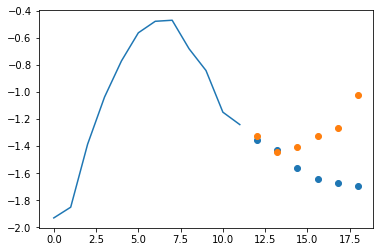

In [142]:
plt.plot(test_temp[0])
plt.scatter(z,y_predict_LR[0])
plt.scatter(z,test_label[0])

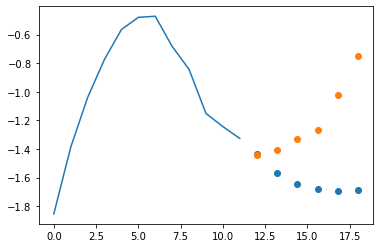

In [143]:
plt.plot(test_temp[1])
plt.scatter(z,y_predict_LR[1])
plt.scatter(z,test_label[1])

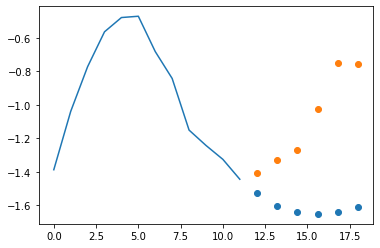

In [144]:
i = 2
plt.plot(test_temp[i])
plt.scatter(z,y_predict_LR[i])
plt.scatter(z,test_label[i])

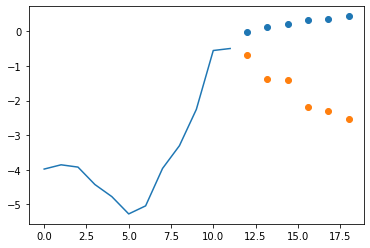

In [145]:
i = 103
plt.plot(test_temp[i])
plt.scatter(z,y_predict_LR[i])
plt.scatter(z,test_label[i])

# Model comparison


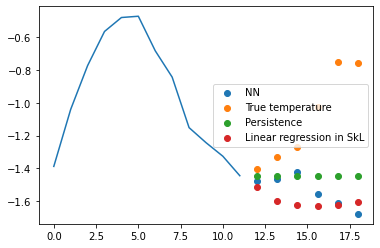

In [146]:
i = 2
z = np.linspace(past, past+future,future)
plt.plot(test_temp[i])
plt.scatter(z,y_predict[i], label = 'NN')
plt.scatter(z,test_label[i], label = 'True temperature')
plt.scatter(z,y_persistence[i], label= 'Persistence')
plt.scatter(z,predict_label[i], label='Linear regression in SkL')
#plt.scatter(z,y_predict_LR[i], label='Linear regression in Keras')

plt.legend(loc='best')



## MSE

> We will check how MSE grows for predicted value on time axis.

In [147]:
def mse(predict):
  mse = np.ones((future,))
  for i in range(future):
     mse[i]= np.mean((test_label[:,i]-predict[:,i])**2)
  return mse 
   

In [148]:
mse(y_persistence)

array([0.35974392, 1.07377119, 2.07997292, 3.28066139, 4.64538988,
       6.02936711])

In [149]:
mse(predict_label)

array([0.26049284, 0.70009607, 1.36578638, 2.21233834, 3.27811273,
       4.36084848])

In [150]:
mse(test_label) #test

array([0., 0., 0., 0., 0., 0.])

In [151]:
mse(y_predict) #NN

array([0.26889957, 0.70823786, 1.34884777, 2.0542681 , 2.97848192,
       3.89022973])

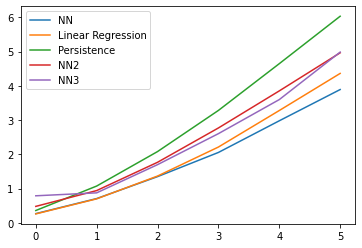

In [152]:
plt.plot(mse(y_predict), label = 'NN')
plt.plot(mse(predict_label), label = 'Linear Regression')
plt.plot(mse(y_persistence), label = 'Persistence')
plt.plot(mse(y_predict2), label = 'NN2')
plt.plot(mse(y_predict3), label = 'NN3')
plt.legend(loc='best')